# Model Selection, Underfitting, and Overfitting
The main purpose of model selection, and under-over fitting detection is
 to achieve the greatest results, while ensuring generalization

### Generalization
When model fits the general data best (not only the training data)

### Model selection
Is a process of trying several models (maybe even different algorithm altogether)
 and picking the best one for the job

### Unfitting
When model doesn't learn enough about the data, oversimplifying its internal relationships

### Overfitting
When the model learns too much about the training data,
 disregarding its internal relationships and memorizing the train dataset

In [1]:
import math
from typing import Any

import numpy as np
import torch
from torch import nn
# noinspection PyTypeChecker
from d2l import torch as d2l

In [2]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.2242],
         [0.6182]]),
 tensor([[1.0000e+00, 2.2425e-01, 2.5143e-02, 1.8794e-03, 1.0536e-04, 4.7255e-06,
          1.7661e-07, 5.6579e-09, 1.5859e-10, 3.9516e-12, 8.8613e-14, 1.8065e-15,
          3.3758e-17, 5.8232e-19, 9.3274e-21, 1.3944e-22, 1.9543e-24, 2.5780e-26,
          3.2117e-28, 3.7906e-30],
         [1.0000e+00, 6.1819e-01, 1.9108e-01, 3.9375e-02, 6.0854e-03, 7.5239e-04,
          7.7520e-05, 6.8461e-06, 5.2903e-07, 3.6338e-08, 2.2464e-09, 1.2625e-10,
          6.5037e-12, 3.0927e-13, 1.3656e-14, 5.6282e-16, 2.1746e-17, 7.9078e-19,
          2.7158e-20, 8.8364e-22]]),
 tensor([5.2206, 5.2980]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [9]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.011233   1.2384437 -3.4000487  5.532472 ]]


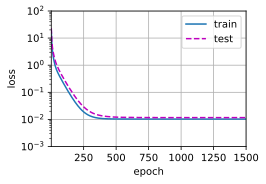

In [9]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:], num_epochs=1500)

weight: [[3.4224138 3.537584 ]]


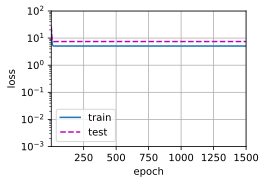

In [10]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:], num_epochs=1500)

weight: [[ 5.0002365   1.2970097  -3.3267066   5.137548   -0.2910768   1.5217137
   0.0787047   0.24683104 -0.14115977  0.12457269 -0.03807335  0.19007504
   0.08210462 -0.04605744  0.0725858   0.11560887 -0.06212276  0.0746223
  -0.10308904  0.09838128]]


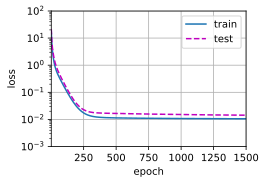

In [11]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)


# Weight Decay
The main purpose of weight decay is
 to restrict model from assigning extreme values to it's weight
 it is also called regularization

### Regularization
Most commonly L2 norm is used for regularization, but there also are other norms

In [12]:
%matplotlib inline
import torch
from torch import nn
# noinspection PyTypeChecker
from d2l import torch as d2l

In [13]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [14]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [15]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [16]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # The L2 norm penalty term has been added, and broadcasting
            # makes `l2_penalty(w)` a vector whose length is `batch_size`
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', torch.norm(w).item())

L2 norm of w: 13.835246086120605


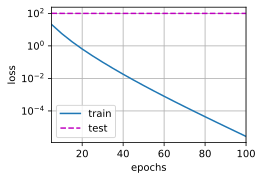

In [17]:
train(lambd=0)

L2 norm of w: 0.36701518297195435


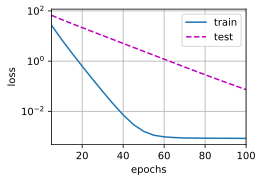

In [18]:
train(lambd=3)

In [19]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # The bias parameter has not decayed
    trainer = torch.optim.SGD([{
        "params": net[0].weight,
        'weight_decay': wd}, {
            "params": net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item())

L2 norm of w: 13.130232810974121


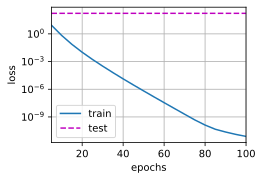

In [20]:
train_concise(0)

L2 norm of w: 0.397270530462265


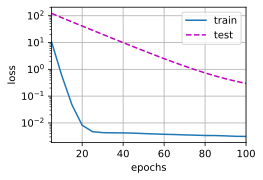

In [21]:
train_concise(3)

# Dropout
Dropout, involves injecting noise while computing each internal layer during forward propagation,
 and it has become a standard technique for training neural networks.
 The method is called dropout because we literally drop out some neurons during training.
 Throughout training, on each iteration, standard dropout consists of zeroing out some fraction of the nodes
 in each layer before calculating the subsequent layer.

In [28]:
import torch
from torch import nn
# noinspection PyTypeChecker
from d2l import torch as d2l
from typing import Any

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return torch.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [29]:
X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  0.,  8.,  0.,  0., 14.],
        [16., 18.,  0.,  0.,  0., 26., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [30]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [31]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def _forward_unimplemented(self, *input: Any) -> None:
        pass

    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # Use dropout only when training the model
        if self.training:
            # Add a dropout layer after the first fully connected layer
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            # Add a dropout layer after the second fully connected layer
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

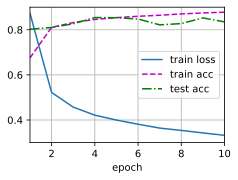

In [32]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [33]:
net = nn.Sequential(
    nn.Flatten(), nn.Linear(784, 256), nn.ReLU(),
    # Add a dropout layer after the first fully connected layer
    nn.Dropout(dropout1), nn.Linear(256, 256), nn.ReLU(),
    # Add a dropout layer after the second fully connected layer
    nn.Dropout(dropout2), nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

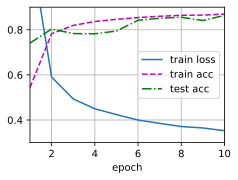

In [34]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# Forward Propagation, Backward Propagation, and Computational Graphs

### Forward Propagation
Applying NN weights to input data to calculate output

### Backwards Propagation
Calculating gradient of NN for every parameter
(propagating network from finish to start aka backpropagation)

# Numerical Stability and Initialization

### Initialization
NN initialization is important in order to not land initial weight to area with very small (or exploding) gradient.

### Backwards Propagation
Calculating gradient of NN for every parameter
(propagating network from finish to start aka backpropagation)

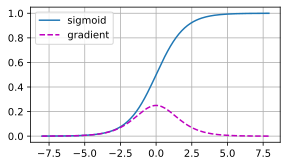

In [37]:
%matplotlib inline
import torch
# noinspection PyTypeChecker
from d2l import torch as d2l

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

In [38]:
M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n', M)
for i in range(100):
    M = torch.mm(M, torch.normal(0, 1, size=(4, 4)))

print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[-1.0840, -0.1730,  1.5659,  0.1516],
        [-1.2288, -1.2693, -0.1067, -0.3308],
        [ 0.8448, -1.5888,  1.5385,  0.8257],
        [ 1.4861, -0.0865, -0.1766,  0.9733]])
after multiplying 100 matrices
 tensor([[ 1.8060e+23,  4.8444e+22,  1.2471e+23, -1.4130e+23],
        [ 1.6470e+23,  4.4180e+22,  1.1374e+23, -1.2886e+23],
        [-5.0594e+22, -1.3573e+22, -3.4939e+22,  3.9586e+22],
        [-1.7317e+23, -4.6451e+22, -1.1958e+23,  1.3548e+23]])


# Environment and Distribution Shift

### This is about when environment and/or out input data change enough for model to break or behave unpredictably